<h2> A Function Space Model of the SC </h2>

In this notebook we will construct a model of the superior colliculus (SC) based on function spaces. The function space consists of two-variable Gaussian, i.e., a Gaussian defined on a 2D map representing the SC map. To decode the 2D target information from this function space, the center-of-mass method is employed.

<h4> The Function Space Model </h4>

There are two advantages to the function space approach for modeling the SC. The first is that spatial representation can be implemented accurately by having neuron encoders be Gaussian functions. This spatial encoding cannot be done with vectors as vectors in the same direction but with different magnitudes will activate any cell in that direction. The second advantage is that the known constraints on the firing rates and tuning of the cells in the SC map can be included with great ease. 

About a third of the SC map is devoted to the central 10 degrees of visual space. We can include this fact in the model by having the gaussian centers themselves drawn from a Gaussian distribution whose cdf in the 10 degree range is about 0.3. (To be more precise though, this should be done with a 2D multivariate gaussian, this is an approximation)

Second, cells toward the fovea have narrower tuning curves, while cells further towards the periphery have broader tuning curves. We can include this by having the covariance matrix of each Gaussian function encoder depend on the norm of its mean (see ``Gaussian_2D`` function).

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Bu, Bv, A = 1.4, 1.8, 3

def sacc_to_coll(theta, R):
    theta = np.deg2rad(theta)
    hor = Bu * np.log(np.sqrt(R**2 + A**2 + 2*A*R*np.cos(theta))) - Bu * np.log(A)
    ver = Bv * np.arctan2(R * np.sin(theta), R * np.cos(theta) + A)
    return hor, ver


def coll_to_sacc(u, v):
    s_u, s_v = u / Bu, v / Bv
    R = A * np.sqrt(np.exp(2 * s_u) - 2 * np.exp(s_u) * np.cos(s_v) + 1)
    theta = np.rad2deg(np.arctan2(np.exp(s_u) * np.sin(s_v), (np.exp(s_u) * np.cos(s_v) - 1)))
    #theta = np.arctan2(np.exp(s_u) * np.sin(s_v), (np.exp(s_u) * np.cos(s_v) - 1))
    return theta, R

theta, R = 80, 10
print sacc_to_coll(theta, R)
print coll_to_sacc(*sacc_to_coll(theta, R))

(1.8097889770385962, 2.0205008991365574)
(80.0, 10.0)


In [25]:
# note: incorporate data from Van opstal optimal paper about burst properties

import nengo
from nengo.dists import Uniform
from nengo.utils.function_space import Function, FunctionSpace
#nengo.dists.Function = nengo.utils.function_space.Function
#nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

def mesh_and_stack(*axes):
    grid = np.meshgrid(*axes)
    return np.vstack(map(np.ravel, grid)).T

# collicular map approximate limits: hor is 5mm, ver is -3mm to 3mm, derived from mapping above
hlimit, vlimit = 5., 3.
Rmax = 50.
n_points_x, n_points_y = 100, 100
domain = mesh_and_stack(np.linspace(0, hlimit, n_points_x), np.linspace(-vlimit, vlimit, n_points_y))
change_sigma = 10  #  movement fields larger than this value have a larger area

def Gaussian_2D(center_x, center_y):
    x, y = domain[:, 0], domain[:, 1]
    # map to saccade space, and set movement field size based on amplitude
    _, R = coll_to_sacc(center_x, center_y)
    # get a sigma between 0.2 and 0.8 based on the amplitude
    sigma = 0.2 * (1 - R / Rmax) + (R/ Rmax) * 0.8
    return np.exp(((x - center_x)**2 + (y - center_y)**2) / (-2 * sigma**2)) / (2 * np.pi * sigma **2)

#R1, R2 = 2/d, 1/d  # reshaping parameters for displaying gaussians

gauss2D = Function(Gaussian_2D, 
                   center_x=nengo.dists.Uniform(0, hlimit), 
                   center_y=nengo.dists.Uniform(-vlimit, vlimit))

fs = FunctionSpace(gauss2D, n_samples=2000, n_basis=10)

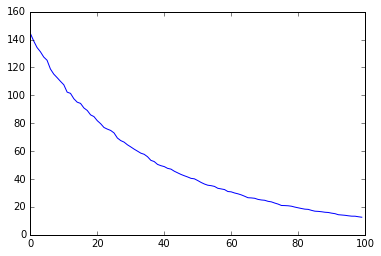

In [32]:
plt.plot(fs.S[:100])

We plot the encoding Gaussians below, note that they appear stretched because the y-axis is twice as large as the x-axis. The reason for the latter is each colliculus (left, right), represents half of the visual field.

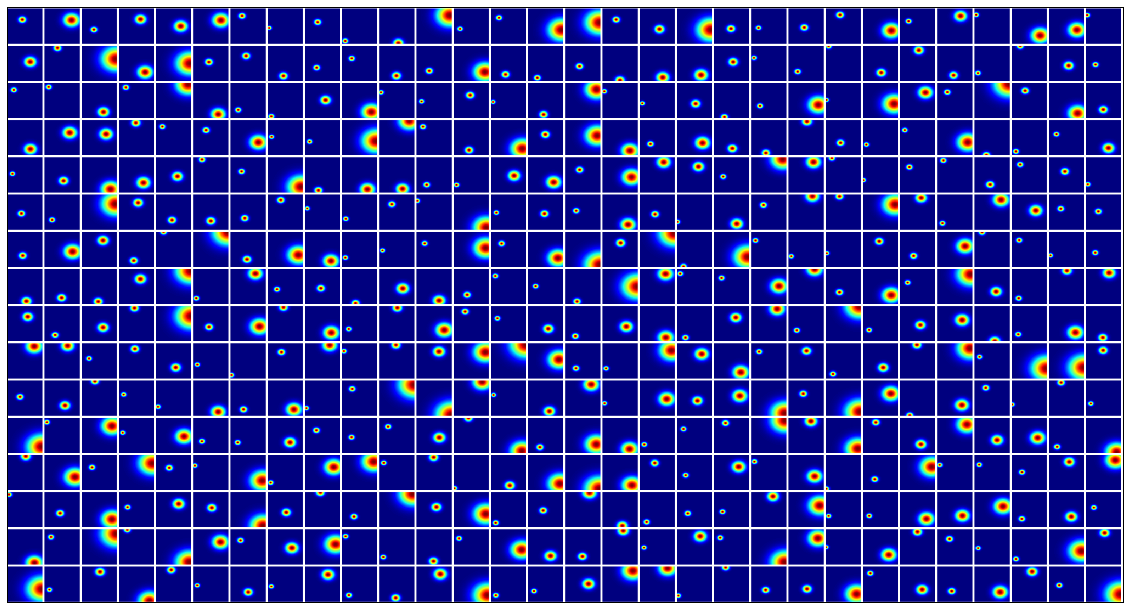

In [22]:
def plot_images(images):
    """Images should be of shape (n_images, dim * dim)"""
    N = images.shape[0]
    plt.figure(figsize=(20,30))
    s = 30
    for i in range(N):
        w = i%s
        h = i/s
        plt.imshow(images[i].reshape((n_points_x, n_points_y)), extent=(w, w+0.95, h, h+0.95),
                   interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.xlim((0, s))
    plt.ylim((0, N/s))

def plot_image(image):
    plt.imshow(image.reshape((n_points_x, n_points_y)), interpolation='none')

plot_images(fs.data[0:500])

<h4> The Center-of-Mass Decoding </h4>

The second important aspect of this model is the decoding method. To obtain the 2D motor command that forms the input to the saccade generator, the center-of-mass of the Gaussian bumps encoded by the SC must be decoded. This gives the location of the center of the bump. Our output function then takes this loction, maps it to saccade motor space, and returns the horizontal and vertical values in those space. We also define an input function that transform from motor space to collicular space.

CM (2.7709020605634453, 0.079793293733838394)
SC_output, hor, ver:  (18.689866440841158, 0.96213358554428918)
actual sacc (12.509758888637968, 0.0)


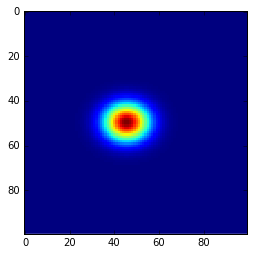

In [38]:
dx = (hlimit / n_points_x)
dy = (2 * vlimit) / n_points_y
dA = dx * dy

# find center of the Gaussian bump
def center_mass(func):
    m = np.sum(func) * dA
    y = domain[:, 1]
    x = domain[:, 0] 
    My = np.dot(func, x) * dA
    Mx = np.dot(func, y) * dA
    return My/m, Mx/m

def center_mass_vec(FS_vector):
    func = fs.reconstruct(FS_vector)
    return center_mass(func)

def polar_to_cart(theta, R):
    theta = np.deg2rad(theta)
    return R * np.cos(theta), R * np.sin(theta)

def SC_output(FS_vector):
    theta, R = coll_to_sacc(*center_mass_vec(FS_vector))
    return polar_to_cart(theta, R)

center_x, center_y = 2.3, 0
target_func = Gaussian_2D(center_x=center_x, center_y=center_y)
plot_image(target_func)

print 'CM', center_mass_vec(fs.project(target_func))
print 'SC_output, hor, ver: ', SC_output(fs.project(target_func))
print 'actual sacc', polar_to_cart(*coll_to_sacc(center_x, center_y))

In [10]:
from nengo.networks.function_space import FS_Ensemble

eval_points = sample_eval_points(Gaussian_2D, FS, 1000, 1, domain, *arg_dists)
model = FS_Ensemble(FS, eval_points=eval_points)
theta, R = 20, 10
u, v = sacc_to_coll(theta, R)
input_func = Gaussian_2D(domain, u, v)

def SC_input(t):
    if t > 0.3 and t < 2:
        return input_func
    else:
        return np.zeros(len(domain))

with model:
    in_node = nengo.Node(output=SC_input)
    nengo.Connection(in_node, model.input)
    h_LLBN = nengo.Ensemble(dimensions=1, n_neurons=400, radius=90)
    v_LLBN = nengo.Ensemble(dimensions=1, n_neurons=400, radius=90)
    nengo.Connection(model.ens, h_LLBN, function=lambda x: SC_output(x)[0])
    nengo.Connection(model.ens, v_LLBN, function=lambda x: SC_output(x)[1])
    h_p = nengo.Probe(h_LLBN, synapse=0.1)
    v_p = nengo.Probe(v_LLBN, synapse=0.1)

print 'building'
s = nengo.Simulator(model)
print 'simulating'
s.run(4)

building
simulating
Simulation finished in 0:00:03.                                                 


(9.3969262078590852, 3.420201433256687)


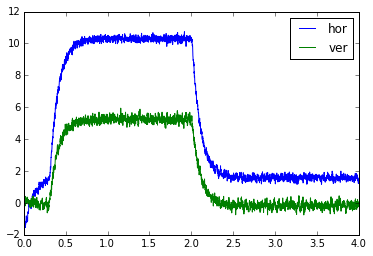

In [11]:
plt.plot(s.trange(), s.data[h_p], label='hor')
plt.plot(s.trange(), s.data[v_p], label='ver')
plt.legend(loc='best')
print polar_to_cart(theta, R)

Note that for a full model this center-of-mass approach must be combined with a WTA mechanism. The WTA mechanism would restrict the activity to one Gaussian bump. The COM approach would extract the 2D command from that.

In [19]:
import numpy as np

import nengo
from nengo.dists import Uniform

dt = 0.001 # timestep
simtime = 5 # number of seconds to run simulation

alpha = 25. # attractor gain value
beta = alpha / 4. # attractor gain value

goal = .1 # goal state

m = nengo.Network('Point attractor')
with m: 

    # --------------------- Inputs --------------------------
    #input_goal = nengo.Node(output=[goal])
    input_goal = nengo.Node(output=lambda t: [goal] if t >0.1 and t < 0.3 else 0)

    # ------------------- Point Attractor --------------------
    # want to set up ddyz = alpha * (beta * (goal - yz) - dyz) + ff

    # the DMP system state = [yz, dyz]
    yz = nengo.Ensemble(n_neurons=150, dimensions=2, radius=5)
                        #neuron_type=nengo.Izhikevich(reset_voltage=-55, reset_recovery=4))

    # set up recurrent connection for system state, which 
    # specify the rate of change of each dimension represented.
    # first row of the transform is dyz, second row is ddyz
    nengo.Connection(yz, yz, transform=np.eye(2) + np.array([[0, 1], [-alpha*beta, -alpha]]),
                        synapse=1)
    # send goal input in to ddyz
    nengo.Connection(input_goal, yz[1],
                        transform=[[alpha*beta]], 
                        synapse=1)

    # set up probes
    probe_y = nengo.Probe(yz, synapse=.05)
    probe_s = nengo.Probe(yz.neurons, 'spikes')

print 'building model...'
s = nengo.Simulator(m, dt=dt)
s.run(simtime)

building model...
Simulation finished in 0:00:03.                                                 


In [20]:

# ------------------------------- Plot data ----------------------------------
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot

plt.subplot(211)
plt.title('Trajectory')
plt.plot(s.trange(), s.data[probe_y][:,0])
plt.plot(s.trange(), np.tile(goal, s.trange().shape), 'r--')

plt.subplot(212)
plt.title('Velocity')
plt.plot(s.trange(), s.data[probe_y][:,1])

plt.figure()
plt.title('Spikes')
rasterplot(s.trange()[:130], s.data[probe_s][:130, :])

plt.grid()
plt.show()